Antimony model compiled without error


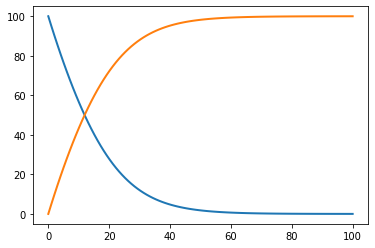

[[<matplotlib.lines.Line2D at 0x1aec5ae4af0>],

In [35]:
import antimony
import roadrunner 
import matplotlib.pyplot as plt 

ant_model = """
model pathway()
  # Examples of different rate laws and initialization


  S3 -> S4; Vm*S3/(Km + S3)


  S3 = 100
  S4 = 0


  Vm = 10
  Km = 100
end
"""

antimony.clearPreviousLoads()
antimony.freeAll()
code = antimony.loadAntimonyString(ant_model)
if code >= 0:
    mid = antimony.getMainModuleName()
    sbml_model = antimony.getSBMLString(mid)
    print('Antimony model compiled without error')

r_model = roadrunner.RoadRunner(sbml_model)

r_solved = r_model.simulate(0, 100, 100)

r_model.plot()

# print(r_solved)
# plt.plot(r_solved)


In [11]:
# The following function generates antimony strings from high level syntax 
from inspect import Parameter
from typing import Union, Tuple, List 
from models.ReactionArchtype import ReactionArchtype
from models.Reaction import Reaction

class AntimonyModel:

    def __init__(self, name):
        self.name = name
        self.reactions: List[Reaction] = []
        # co-pilot generated, not sure if this is necessary
        self.ant_model = ''
        self.sbml_model = ''
        self.r_model = ''
        self.r_solved = ''
        self.r_plot = ''


    def get_parameters(self):

        '''
        Extracts parameters and their values from all reactions 
        in the class and returns a dict while subjecting to a naming rule 
        
        '''

        parameters_names = []
        parameters = {}
        i = 0 
        while i < len(self.reactions):
            r = self.reactions[i]
            # first, get the parameters names from the archtype
            # and perform naming rule 

            '''
            Here, a simple naming rule is implemented. It simply appends the reaction index 
            to the parameter name
            TODO: implement more complex naming rules in the future 
            '''
            r_index = f'J{i}'

            parameters.update(r.get_reaction_parameters(r_index))

            i += 1

        return parameters

    def get_state_variables(self):

        '''
        Extracts state variables and their values from all reactions 
        in the class and returns a dict

        non-unique state variables will only be repeated once, their 
        default value will only follow the first repeated state variable
        '''

        states_list = {}
        for r in self.reactions: 
            states_list.update(r.get_reaction_states())
        
        return states_list

    def add_reaction(self, reaction: Reaction):
        self.reactions.append(reaction)

    def compile_antimony(self):
        
        antimony_string = ''

        antimony_string += f'model {self.name}\n\n'

        # add reactions
        i = 0 
        while i < len(self.reactions):
            r = self.reactions[i]
            r_index = f'J{i}'
            antimony_string += r.get_antimony_reaction_str(r_index)
            antimony_string += '\n'
            i += 1

        # add state vars 
        antimony_string += '\n'
        antimony_string += '# State variables in the system\n'
        all_states = self.get_state_variables()
        for key, val in all_states.items():
            antimony_string += f'{key}={val}\n'
        antimony_string += '\n'
        
        # add parameters
        antimony_string += '# Parameters in the system\n'
        all_params = self.get_parameters()
        for key, val in all_params.items():
            antimony_string += f'{key}={val}\n'

        antimony_string += '\nend'

        return antimony_string


In [39]:


michaelis_menten = ReactionArchtype(
    'Michaelis Menten', 
    ('S'), ('E'), 
    ('Km', 'Vmax'), 
    'Vmax*S/(Km + S)', 
    assume_parameters_values={'Km': 100, 'Vmax': 10},
    assume_reactant_values={'S': 100},
    assume_product_values={'E': 0})

mass_action_21 = ReactionArchtype(
    'Mass Action',
    ('A', 'B'), ('C'),
    ('ka', 'kd'),
    'ka*A*B - kd*C',
    assume_parameters_values={'ka': 0.001, 'kd': 0.01},
    assume_reactant_values={'A': 100, 'B': 100},
    assume_product_values={'C': 0})

r1 = Reaction(michaelis_menten, ('iSFK',), ('SFK',))
r2 = Reaction(michaelis_menten, ('SFK',), ('iSFK',))

print(r1)
print(r2)


r3 = Reaction(michaelis_menten, ('iSFK',), ('SFK',), parameters_values={'Km': 0.2, 'Vmax': 0.2},
              reactant_values={'iSFK': 100}, product_values={'SFK': 0})  

r4 = Reaction(michaelis_menten, ('SFK',), ('iSFK',), parameters_values={'Km': 0.2, 'Vmax': 0.2},
                reactant_values=(50,), product_values=(50,))

r5 = Reaction(michaelis_menten, ('SFK',), ('iSFK',), parameters_values={'Km': 0.2, 'Vmax': 0.2},
              reactant_values=200, product_values=100)


print(r3.get_reaction_parameters(r_index='J0'))
print(r3.get_reaction_states())

print(r4.get_reaction_parameters(r_index='J0'))
print(r4.get_reaction_states())

print(r5.get_reaction_parameters(r_index='J0'))
print(r5.get_reaction_states())

r6 = Reaction(mass_action_21, ('A', 'B'), ('C'), parameters_values={'ka': 0.1, 'kd': 0.01},
                reactant_values={'B': 200}, product_values=(50,))

print(r6.get_reaction_parameters(r_index='J0'))
print(r6.get_reaction_states())
print(r6)

react: iSFK -> SFK; react_Vmax*iSFK/(react_Km + iSFK)
react: SFK -> iSFK; react_Vmax*SFK/(react_Km + SFK)
{'J0_Km': 0.2, 'J0_Vmax': 0.2}
{'iSFK': 100, 'SFK': 0}
{'J0_Km': 0.2, 'J0_Vmax': 0.2}
{'SFK': 50, 'iSFK': 50}
{'J0_Km': 0.2, 'J0_Vmax': 0.2}
{'SFK': 200, 'iSFK': 100}
{'J0_ka': 0.1, 'J0_kd': 0.01}
{'A': 100, 'B': 200, 'C': 50}
react: A + B -> C; react_ka*A*B - react_kd*C


In [40]:
model = AntimonyModel('test')
model.add_reaction(r1)
# model.add_reaction(r6)
print(model.compile_antimony())


model test

J0: iSFK -> SFK; J0_Vmax*iSFK/(J0_Km + iSFK)

# State variables in the system
iSFK=100
SFK=0

# Parameters in the system
J0_Km=100
J0_Vmax=10

end


Antimony model compiled without error


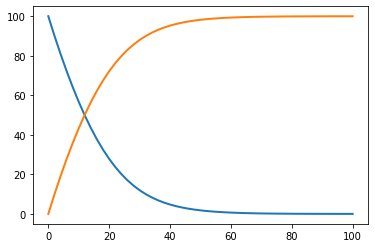

[[<matplotlib.lines.Line2D at 0x1aec5c39ca0>],

In [42]:
import antimony
import roadrunner
import matplotlib.pyplot as plt

ant_model = model.compile_antimony()


antimony.clearPreviousLoads()
antimony.freeAll()
code = antimony.loadAntimonyString(ant_model)
if code >= 0:
    mid = antimony.getMainModuleName()
    sbml_model = antimony.getSBMLString(mid)
    print('Antimony model compiled without error')

r_model = roadrunner.RoadRunner(sbml_model)

r_solved = r_model.simulate(0, 100)

r_model.plot()
